In [119]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import warnings
import networkx as nx
import matplotlib.colors as mcolors
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import naive_greedy_modularity_communities
from networkx.algorithms.community import label_propagation_communities
import networkx.algorithms.community as nx_comm
from networkx.algorithms.connectivity.edge_kcomponents import bridge_components
import glob 
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.readwrite import json_graph
import json
from itertools import islice
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.ticker as tk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier 
import torch 
import torch.nn as nn
import torch.optim as optim
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import GraphicalLassoCV
from networkx.generators.community import gaussian_random_partition_graph
from scipy.stats import ttest_ind

In [120]:
#start with formattting data, getting master csv of all patients regional volume 
#create master csv file with all vol for each region for eahc patient
#cols would be 'id','001','002'....
#rows would be id numbers 0173

#fiugre out why this isnt working correctly 
#change this for NACC dataset

dir = "/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi"
data_dic = {}
patient_data = {}
#iterate through patient folders to extract the values of the .npy files 
#need touble check this by printing id because NACC folders have naming convention NACC[0-9][0-9][0-9][0-9][0-9][0-9]
for folder in sorted(glob.glob(os.path.join(dir,"NACC*"))):
    # print(f"processing: {folder}")
    id = folder[-6:]

    # print(id)
    volumes = []
    #data dicitonary to store corresponding labels and values 
    for file in sorted(glob.glob(os.path.join(folder, "*.npy"))): #search for all .npy files 
        reg_num = os.path.splitext(os.path.basename(file))[0] #os.path.basename returns filename itself with extension
        #os.path.splittext()[0] splits file basename into a tuple of file name string and the extension (001,.npy) [0] tells it to extract first el of this tuple (001)
        # print(reg_num)
        node_data = np.load(file)
        # print(reg_num, node_data)
        data_dic[reg_num]=node_data
        volumes.append(node_data)

    patient_data[id]=volumes

patient_ids = list(patient_data.keys())

df = pd.DataFrame.from_dict(patient_data,orient='index')
df.columns = [str(int(col) + 1) for col in df.columns]
df['RID'] = patient_ids
#only pad ids that are not already 6 digits 
df['RID']=df['RID'].apply(lambda x: f"NACC{x:0>6}")
#make rid col the index (first col)
df = df.set_index('RID').reset_index()


#adding a weird last row to the df with empty values so drop is 
df = df.drop(df.index[-1],axis=0)
#save
df.to_csv('/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/mega_NACC.csv')

prog "RID" and format NACC000000 (padded 0s)

to match I need the df col to be renamed 'RID' and then add NACC and padded 0s

In [121]:
#add in progression info and then split dataframes into stable and progressive mci 
#find nacc prog info 

prog_info = pd.read_csv("/data2/MRI_PET_DATA/graph/csvs/NACC_surv_prog.csv")
# all_df = pd.read_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/hip_weights.csv") #doesn't work if I just read it in as a csv weird 

prog = prog_info[['RID',"PROGRESSES"]]
#add in padded zeros to prog df 
prog['RID']=prog["RID"].astype(str).str.zfill(4)

prog = prog[prog["RID"].isin(df['RID'].astype(str))]

prog=prog.reset_index(drop=True)
# print(f"N Progressive MCI={prog['PROGRESSES'].value_counts()[1]}\nN Stable MCI={(545-154)}")  #in entire dataset, only 154 who progress 
print(f"N Progressive MCI={prog['PROGRESSES'].value_counts()}\nN Stable MCI={(508-378)}")

#merge all_df df and prog df on index RID and ID
merged = pd.merge(prog,df,on='RID')
# print(merged)
#original 
# merged = merged.drop('RID',axis=1)


N Progressive MCI=0    378
1    130
Name: PROGRESSES, dtype: int64
N Stable MCI=130


/tmp/ipykernel_1537782/1198575433.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog['RID']=prog["RID"].astype(str).str.zfill(4)


In [122]:
#separate dfs for progressors and stable 
#creat empty dfs 
progs = pd.DataFrame()
stable = pd.DataFrame()

for index,row in merged.iterrows():
    if row['PROGRESSES']==1:
        progs = progs.append(row)
    else:
        stable = stable.append(row)

# print(progs)
# print(stable)

progs.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_progressors_vol.csv")
stable.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_stable_vol.csv")

In [123]:
#drop row 23 and 25 because they are ventricle and chiasm and have no volume 
# zero_col = df.columns[(df ==0).any()]
# print(zero_col)

#drop 1,2,3,4,23,24,25,26,35,36

progs = progs.drop(['1','2','3','4','23','24','25','26','35','36'], axis =1)
stable = stable.drop(['1','2','3','4','23','24','25','26','35','36'], axis =1)

#drop all the ventricles and region 001 because its the background and not the data we need 
#in this the bacground region 0 and region 1 are both combined in region 1 
progs.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_progressors_pruned_vol.csv")
stable.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_stable_pruned_vol.csv")

In [124]:
#for the correlation matrix need to only have the values 
progs = progs.drop(["RID","PROGRESSES"], axis =1)
stable = stable.drop(["RID","PROGRESSES"], axis =1)

#convert to float
progs = progs.astype(float)
stable = stable.astype(float)
# print(stable)

In [125]:
#no nan values in df nom
#normalize with z score, negative values are fine it means its an std below mean 
progs_norm = (progs - progs.mean()) / progs.std()
stable_norm = (stable - stable.mean()) / stable.std()
print(progs_norm)
# progs_norm = progs_norm.reset_index(drop=True)
# progs_norm = progs_norm.reset_index(drop=True)

            5         6         7         8         9        10        11  \
5    0.428046  0.010639 -1.197057  1.858992 -0.627599 -0.257902  0.685724   
7    0.428046 -0.911413  0.114326  0.529314 -0.990480 -0.833689  0.685724   
8    0.046909  0.471665  0.114326  1.194153 -0.990480 -0.060489  0.142162   
16   0.428046  0.932691  0.551453 -0.467944 -0.809039  0.531749  0.413943   
21  -0.715364  0.010639 -0.322802  0.196895 -0.506638 -0.603374 -1.216743   
..        ...       ...       ...       ...       ...       ...       ...   
481 -1.096501  0.010639 -0.322802  0.529314 -0.567119  0.317885  1.229287   
492  0.428046 -0.911413  0.114326  0.529314 -1.232401 -0.241451 -0.401400   
493  0.428046  0.932691  0.114326 -0.135525 -2.079124 -1.162710  0.685724   
495 -1.858775 -1.372438 -0.759930  0.196895 -0.204237 -0.011136  1.501068   
505 -1.096501  0.932691  0.114326  0.529314  0.158644 -2.791366  0.413943   

           12        13        14  ...       133       134       135  \
5  

In [126]:
print(len(progs_norm))

130


In [129]:
#gaussian graphical model
#everytime I transpose it flips the data so need to make sure its patients x regions 

#transpose data so that each region is a row instead of a col because that's how the data will be handled 

#NEEDS TO BE 130x 132 format for model  (32 brain regions left)
progs_norm = progs_norm.T
print(progs_norm)

            5         6         7         8         9        10        11  \
5    0.428046  0.010639 -1.197057  1.858992 -0.627599 -0.257902  0.685724   
7    0.428046 -0.911413  0.114326  0.529314 -0.990480 -0.833689  0.685724   
8    0.046909  0.471665  0.114326  1.194153 -0.990480 -0.060489  0.142162   
16   0.428046  0.932691  0.551453 -0.467944 -0.809039  0.531749  0.413943   
21  -0.715364  0.010639 -0.322802  0.196895 -0.506638 -0.603374 -1.216743   
..        ...       ...       ...       ...       ...       ...       ...   
481 -1.096501  0.010639 -0.322802  0.529314 -0.567119  0.317885  1.229287   
492  0.428046 -0.911413  0.114326  0.529314 -1.232401 -0.241451 -0.401400   
493  0.428046  0.932691  0.114326 -0.135525 -2.079124 -1.162710  0.685724   
495 -1.858775 -1.372438 -0.759930  0.196895 -0.204237 -0.011136  1.501068   
505 -1.096501  0.932691  0.114326  0.529314  0.158644 -2.791366  0.413943   

           12        13        14  ...       133       134       135  \
5  

In [133]:
print(progs_norm.isna().sum())

5      0
6      0
7      0
8      0
9      0
      ..
138    0
139    0
140    0
141    0
142    0
Length: 132, dtype: int64


In [130]:
#graphical lasso 
#estimates the precision matrix of the data (inverse cov mat which models the partial correlations between vars)
#uses lasso penalty, during training the model iteratively updates the estimated precision matrix using current hyperparamter values until it converges to a set of values that minimize the loss function 
model = GraphicalLassoCV(cv=5) #cv=5 specifies 5-fold cross validation strategy to optimize model hyperparameters 
model.fit(progs_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=5)

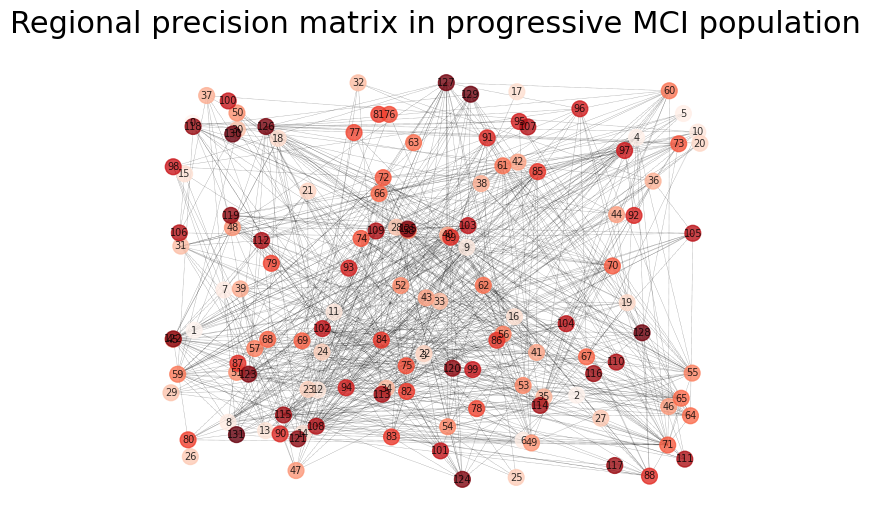

In [134]:
#represents conditional independence structure of data, strength and direction of a relationship between 
#this graph has learned and pruned the weaker connections in the precision matrix
#graph represents the strongest and most important connections between the brain volume 


precision_matrix_p = model.precision_
np.fill_diagonal(precision_matrix_p, 0)
G_prog = nx.Graph(precision_matrix_p)
pos = nx.random_layout(G_prog)
nx.draw(G_prog, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_p)),
        cmap=plt.cm.Reds, node_size=150*len(precision_matrix_p)/154, alpha=.8, width=.3)
#size inconsistent and makes me enter 
plt.title("Regional precision matrix in progressive MCI population", fontsize=22)
plt.show()


In [135]:
#strongest edges 
#right now its showing edge 0 (background) as being connected strongly with everything because its the background, need to figure out how I would fix this 
#or it could be that the edges start at 0 and I just need to rename them to get it to start at 1 

edges_sorted = sorted(G_prog.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(edge[0]+1, edge[1]+1, edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(8, 14, {'weight': 0.8081280916439814})
(14, 52, {'weight': 0.5846940558012397})
(8, 22, {'weight': 0.5420483736426855})
(14, 38, {'weight': 0.3971330780432793})
(22, 52, {'weight': 0.26123246493864094})
(13, 21, {'weight': 0.25501459715961994})
(13, 67, {'weight': 0.24904302557367547})
(46, 102, {'weight': 0.23550528347468172})
(22, 46, {'weight': 0.2040683771810523})
(13, 19, {'weight': 0.18903509139145883})


In [ ]:
#stable model and graph 
#NEEDS TO BE 378x 132 format for model  (32 brain regions left)
stable_norm = stable_norm.T
print(stable_norm)

In [138]:
#stable model 
#fit for stable norm df 
stab_model = GraphicalLassoCV(cv=5)
stab_model.fit(stable_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 9.153e-04
  warnings.warn(


GraphicalLassoCV(cv=5)

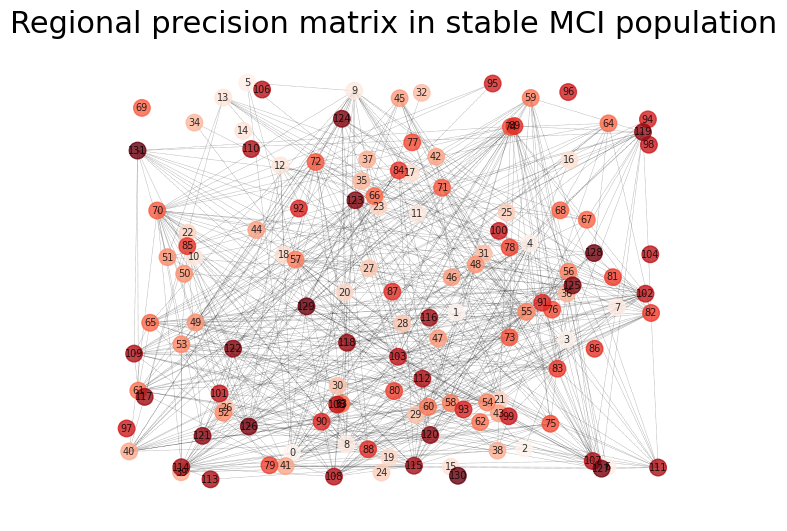

In [ ]:
#stable graph 
precision_matrix_s = stab_model.precision_
np.fill_diagonal(precision_matrix_s, 0)
G_stab = nx.Graph(precision_matrix_s)
pos = nx.random_layout(G_stab)
nx.draw(G_stab, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_s)),
        cmap=plt.cm.Reds, node_size=150*len(precision_matrix_s)/140, alpha=.8, width=.3)
plt.title("Regional precision matrix in stable MCI population", fontsize=22)
plt.show()

In [ ]:
#top 10 strongest edges in stable 
edges_sorted = sorted(G_stab.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(edge[0]+1, edge[1]+1, edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)


(8, 22, {'weight': 0.6654628847341104})
(8, 100, {'weight': 0.590366683206648})
(13, 21, {'weight': 0.3298110262672875})
(46, 100, {'weight': 0.26497414450752155})
(8, 14, {'weight': 0.2558890942096627})
(14, 68, {'weight': 0.24919727692235774})
(13, 67, {'weight': 0.20745862879657145})
(14, 38, {'weight': 0.12752115284126436})
(22, 46, {'weight': 0.12064692506015218})
(7, 13, {'weight': 0.12007050173735036})


In [ ]:
#compare graph metrics 

#modularity 
mod_p = nx.algorithms.community.modularity(G_prog, nx.algorithms.community.greedy_modularity_communities(G_prog))
print("Prog Modularity:", mod_p)
mod_s = nx.algorithms.community.modularity(G_stab, nx.algorithms.community.greedy_modularity_communities(G_stab))
print("Stable Modularity:", mod_s)

#global path effiency 
ge_p = nx.global_efficiency(G_prog)
print("\nProg Global efficiency:", ge_p)
ge_s = nx.global_efficiency(G_stab)
print("Stable Global efficiency:", ge_s)

#clustering coefficient 
cl_p = nx.average_clustering(G_prog)
print(f"\nProg Clustering Coeff:",cl_p)
cl_s = nx.average_clustering(G_stab)
print(f"Stable Clustering Coeff",cl_s)




Prog Modularity: 0.22721855141293468
Stable Modularity: 0.4517573412616496

Prog Global efficiency: 0.41277662117353375
Stable Global efficiency: 0.22132970930681148

Prog Clustering Coeff: 0.2832195453170149
Stable Clustering Coeff 0.4227596075337266


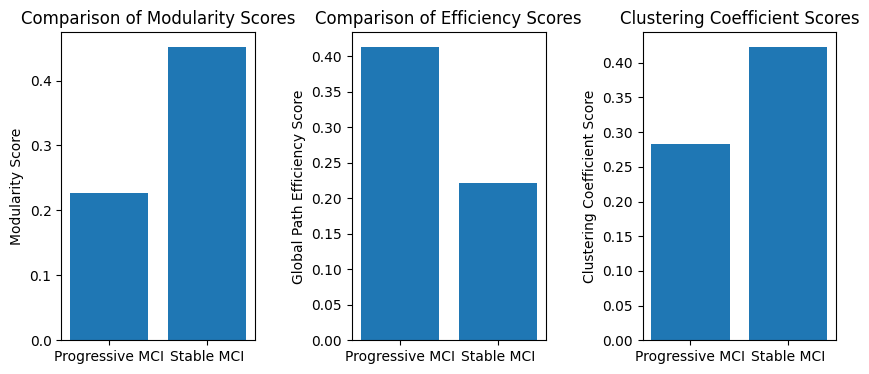

In [ ]:

# Define the data for the three bar plots
m_scores = [mod_p, mod_s]
g_scores = [ge_p, ge_s]
c_scores = [cl_p, cl_s]

labels = ["Progressive MCI", "Stable MCI"]

# Create a figure with three subplots, one for each bar plot
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# first subplot
axs[0].bar(labels, m_scores)
axs[0].set_ylabel("Modularity Score")
axs[0].set_title("Comparison of Modularity Scores")

# second subplot
axs[1].bar(labels, g_scores)
axs[1].set_ylabel("Global Path Efficiency Score")
axs[1].set_title("Comparison of Efficiency Scores")

#third subplot
axs[2].bar(labels, c_scores)
axs[2].set_ylabel("Clustering Coefficient Score")
axs[2].set_title("Clustering Coefficient Scores")

# Adjust the spacing between subplots and display the figure
plt.subplots_adjust(wspace=0.5)
plt.show()


In [ ]:
#significance test 
#Mann whitney bc uneven sample sizes 

# mod_t, mod_pval = ttest_ind(mod_p, mod_s, equal_var=False)
# ge_t, ge_pval = ttest_ind(ge_p, ge_s,equal_var=False)
# cl_t, cl_pval = ttest_ind(cl_p, cl_s,equal_var = False)

# # Print the t-statistics and p-values for each test
# print("Modularity t-statistic:", mod_t, "p-value:", mod_pval)
# print("Global efficiency t-statistic:", ge_t, "p-value:", ge_pval)
# print("Clustering coefficient t-statistic:", cl_t, "p-value:", cl_pval)

from scipy.stats import mannwhitneyu

# Calculate test statistics and p-values for each metric
mod_u, mod_pval = mannwhitneyu(mod_p, mod_s)
ge_u, ge_pval = mannwhitneyu(ge_p, ge_s)
cl_u, cl_pval = mannwhitneyu(cl_p, cl_s)

# Print results
print("Modularity U-statistic:", mod_u)
print("Modularity p-value:", mod_pval)
print("Global efficiency U-statistic:", ge_u)
print("Global efficiency p-value:", ge_pval)
print("Clustering coefficient U-statistic:", cl_u)
print("Clustering coefficient p-value:", cl_pval)

#says there is no significant difference between groups 


Modularity U-statistic: 0.0
Modularity p-value: 1.0
Global efficiency U-statistic: 1.0
Global efficiency p-value: 1.0
Clustering coefficient U-statistic: 0.0
Clustering coefficient p-value: 1.0
